In [107]:
# Setup


import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import joblib
import mlflow
from mlflow.models import infer_signature


#Defining dataset

dataset_ = fetch_ucirepo(id=162) # 162 for forest fires
X = dataset_.data.features 
y = dataset_.data.targets
data_ = pd.concat([X, y], axis = 1)

# Creating the classes

class DataExplorer:
    @staticmethod
    def explore_data(data_):
        print(data_.head().T)
        print(data_.describe())
        print(data_.info())
    
    @staticmethod
    def plot_histograms(data_):
        data_.hist(bins=15, figsize=(15, 10))
        plt.show()

    def data_exp_n_prep(data_):
        print("\nValores nulos por columna:")
        print(data_.isnull().sum())

class FF_model:
    def __init__(self, data_):
        self.data_ = data_

    def data_prep(self):
        
        data = data_.dropna()

        print(f"\nNúmero de filas duplicadas: {data.duplicated().sum()}")
        data = data.drop_duplicates()
        print(f"Número de filas después de eliminar duplicados: {data.shape[0]}")

        Q1 = data['area'].quantile(0.25)
        Q3 = data['area'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data_filtered = data[(data['area'] >= lower_bound) & (data['area'] <= upper_bound)]
        print(f"Cantidad de datos después de eliminar outliers: {data_filtered.shape[0]}")

        data_filtered['log_area'] = np.log1p(data_filtered['area'])

        data_filtered.to_csv(f'../data/processed/{"forest_fires_prepared_df.csv"}', index=False)

    def data_processing(self):

        processed_data = pd.read_csv(f'../data/processed/{"forest_fires_prepared_df.csv"}')

        label_encoder_month = LabelEncoder()
        label_encoder_day = LabelEncoder()
        processed_data['month'] = label_encoder_month.fit_transform(processed_data['month'])
        processed_data['day'] = label_encoder_day.fit_transform(processed_data['day'])

        processed_data['area'] = np.log(processed_data['area'] + 1)

        scaler = StandardScaler()
        numerical_features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
        processed_data[numerical_features] = scaler.fit_transform(processed_data[numerical_features])

        X = processed_data.drop(columns=['area'])
        y = processed_data['area']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        file_path = f'../data/processed'

        X_train.to_csv(f'{file_path}/X_train_processed.csv', index=False)
        X_test.to_csv(f'{file_path}/X_test_processed.csv', index=False)
        y_train.to_csv(f'{file_path}/y_train_processed.csv', index=False)
        y_test.to_csv(f'{file_path}/y_test_processed.csv', index=False)

        processed_data.to_csv(f'{file_path}/forest_fires_processed_df.csv', index=False)
    
    def model_creation(self,file_path=f'../data/processed'):

        X_train = pd.read_csv(f'{file_path}/X_train_processed.csv')
        X_test = pd.read_csv(f'{file_path}/X_test_processed.csv')
        y_train = pd.read_csv(f'{file_path}/y_train_processed.csv')
        y_test = pd.read_csv(f'{file_path}/y_test_processed.csv')

        results = {}
        
        linear_model = LinearRegression()
        linear_model.fit(X_train, y_train)
        y_pred_lr = linear_model.predict(X_test)
        rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
        r2_lr = r2_score(y_test, y_pred_lr)
        results["Regresión Lineal"] = {'RMSE': rmse_lr, 'R²': r2_lr}

        rf_model = RandomForestRegressor(random_state=42)
        rf_model.fit(X_train, y_train['area'])
        y_pred_rf = rf_model.predict(X_test)
        rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
        r2_rf = r2_score(y_test, y_pred_rf)
        results["Random Forest"] = {'RMSE': rmse_rf, 'R²': r2_rf}

        svm_model = SVR(kernel='rbf')
        svm_model.fit(X_train, y_train['area'])
        y_pred_svm = svm_model.predict(X_test)
        rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))
        r2_svm = r2_score(y_test, y_pred_svm)
        results["SVM"] = {'RMSE': rmse_svm, 'R²': r2_svm}

        gb_model = GradientBoostingRegressor(random_state=42)
        gb_model.fit(X_train, y_train['area'])
        y_pred_gb = gb_model.predict(X_test)
        rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
        r2_gb = r2_score(y_test, y_pred_gb)
        results["Gradient Boosting"] = {'RMSE': rmse_gb, 'R²': r2_gb}

        print("\nResultados de Evaluación:")
        for model_name, metrics in results.items():
            print(f"{model_name}:")
            print(f"  RMSE: {metrics['RMSE']}")
            print(f"  R²: {metrics['R²']}")
            print("\n")

        model_names = list(results.keys())
        rmse_values = [metrics['RMSE'] for metrics in results.values()]
        plt.figure(figsize=(10, 6))
        plt.barh(model_names, rmse_values, color='skyblue')
        plt.xlabel('RMSE')
        plt.title('Comparación de RMSE entre Modelos, corrida de prueba')
        plt.show()


    def mlflow_tracking(self,file_path=f'../data/processed',mlserverURI="http://127.0.0.1:5000"):

        X_train = pd.read_csv(f'{file_path}/X_train_processed.csv')
        X_test = pd.read_csv(f'{file_path}/X_test_processed.csv')
        y_train = pd.read_csv(f'{file_path}/y_train_processed.csv')
        y_test = pd.read_csv(f'{file_path}/y_test_processed.csv')
        
        #MLFflow Tracking
        mlflow.set_tracking_uri(mlserverURI)
        mlflow.set_experiment("MLForestFires")

        models = {
        "LinearRegression": LinearRegression(),
        "RandomForestRegressor": RandomForestRegressor(random_state=42),
        "SVM": SVR(kernel='rbf'),
        "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42)
        } 

        best_rmse = float("inf")  # Initialize a variable to track the best RMSE
        best_r2 = None # Initialize a variable to track the best R2
        best_mad = None # Initialize a variable to track the best MAD
        best_run_id = None  # Track the best run's ID
        
        for model_name, model in models.items():
            with mlflow.start_run(run_name=model_name):

                model.fit(X_train, y_train)

                y_pred = model.predict(X_test)
                
                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                # Calculate R2
                r2 = r2_score(y_test, y_pred)                
                 # Calculate MAD
                mad = mean_absolute_error(y_test, y_pred)

                mlflow.log_param("model", model_name)

                # Log metrics
                mlflow.log_metric("rmse", rmse)
                mlflow.log_metric("r2", r2)
                mlflow.log_metric("mad", r2)
                
                mlflow.sklearn.log_model(model, model_name)
            
                mlflow.end_run()
                
    def best_model_run(self):
        # Fetch all runs from the experiment
        experiment_id = mlflow.get_experiment_by_name("MLForestFires").experiment_id
        runs = mlflow.search_runs(experiment_ids=[experiment_id])

        # Find the run with the lowest RMSE
        best_run = runs.sort_values("metrics.rmse", ascending=True).iloc[0]
        
        print(f"Best run is the model {best_run['tags.mlflow.runName']} with RMSE: {best_run['metrics.rmse']} with ID:{best_run['run_id']}")

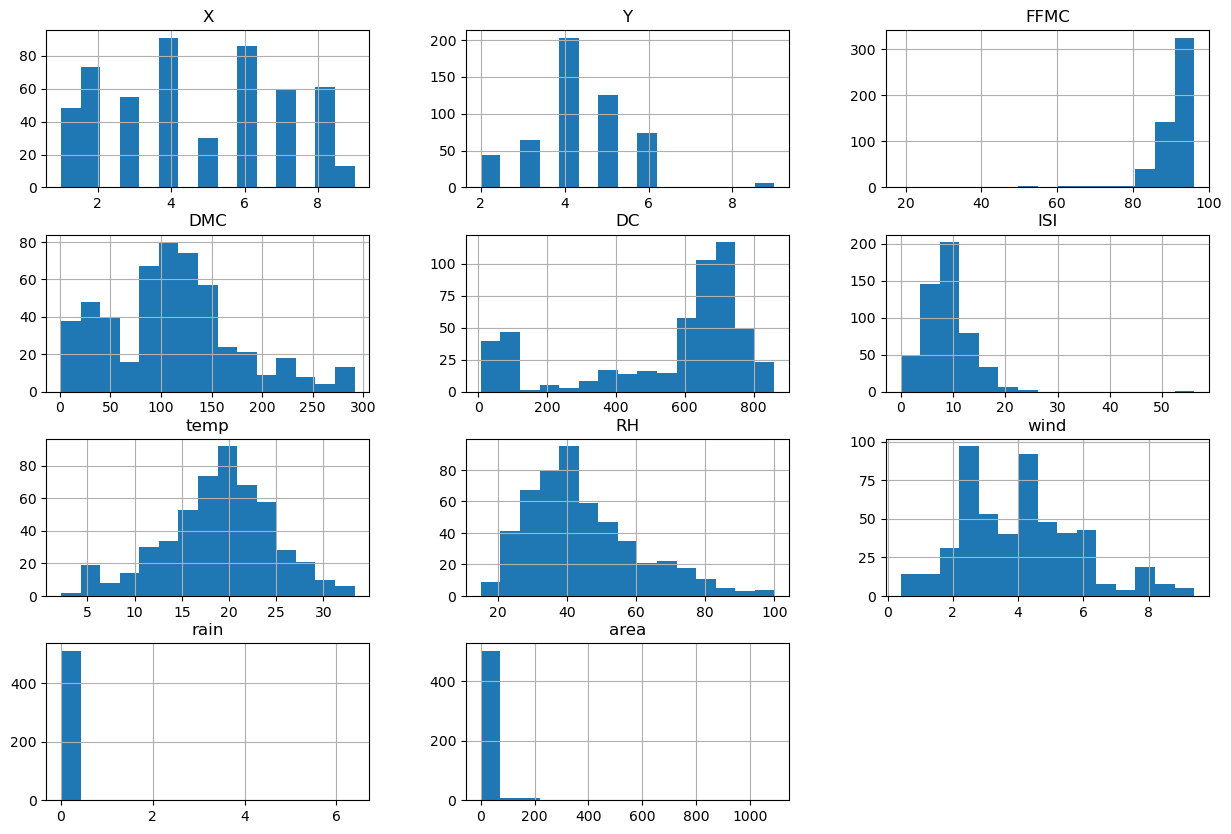

In [14]:
DataExplorer.plot_histograms(data_)

In [16]:
DataExplorer.data_exp_n_prep(data_)


Valores nulos por columna:
X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64


In [17]:
DataExplorer.explore_data(data_)

          0      1      2     3      4
X         7      7      7     8      8
Y         5      4      4     6      6
month   mar    oct    oct   mar    mar
day     fri    tue    sat   fri    sun
FFMC   86.2   90.6   90.6  91.7   89.3
DMC    26.2   35.4   43.7  33.3   51.3
DC     94.3  669.1  686.9  77.5  102.2
ISI     5.1    6.7    6.7   9.0    9.6
temp    8.2   18.0   14.6   8.3   11.4
RH       51     33     33    97     99
wind    6.7    0.9    1.3   4.0    1.8
rain    0.0    0.0    0.0   0.2    0.0
area    0.0    0.0    0.0   0.0    0.0
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.60

In [21]:
FF_model.data_processing(data_)


Resultados de Evaluación:
Regresión Lineal:
  RMSE: 1.0751164827080471e-15
  R²: 1.0


Random Forest:
  RMSE: 0.010331916327147417
  R²: 0.9998730207432068


SVM:
  RMSE: 0.14358036238075814
  R²: 0.9754777051333983


Gradient Boosting:
  RMSE: 0.0073025996641503865
  R²: 0.9999365654292065




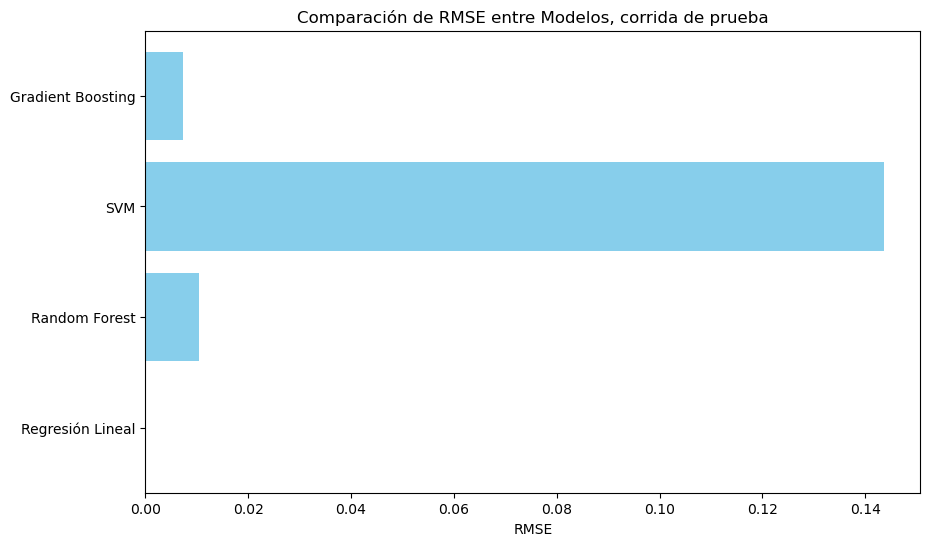

In [91]:
FF_model.model_creation(data_)

In [73]:
FF_model.mlflow_tracking(data_)

2024/10/13 10:24:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/13 10:24:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run LinearRegression at: http://127.0.0.1:5000/#/experiments/508132050770318433/runs/c45d7f337f364626bc1f7853cef9aadb.
2024/10/13 10:24:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/508132050770318433.
/home/olerma/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
2024/10/13 10:24:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model sign

In [109]:
FF_model.best_model_run(data_)

Best run is the model LinearRegression with RMSE: 1.0751164827080471e-15 with ID:c45d7f337f364626bc1f7853cef9aadb
